In [73]:
# Dependencies Import Setup 
#---------------------------
import pandas as pd  
# Pandas is used for data manipulation and analysis, such as reading and working with CSV files.
from pathlib import Path
# The path class provides as easy and platform-independent way to work with file system paths.
import numpy as np
# NumPy is used for numerical operations and working with arrays, which is often helpful in data analysis.
import matplotlib.pyplot as plt
# Pyplot is used to create visualizations like plots and charts.
import requests
# The requests library is used to make HTTP requests, which can be useful for fetching data from web APIs.
import os
# The os module provides a way to interact with the operations system, such as reading enviroment variables or working with file paths
from citipy import citipy
from scipy.stats import linregress
import seaborn as sns
import geopandas as gpd
import folium
import hvplot.pandas
import plotly.graph_objects as go

from api_keys import geoapify_key  

%matplotlib inline
# This is a jupyter notebook magic command
# It tells the notebook to display Matplotlib plots directly within the notebook cells (inline) rather than in a seprarte window.

# CSV Import

#Import API Key

In [74]:
# 1. Data Cleaning & Preperation
# ------------------------------

file_path = Path("\Repos\ev-charging-stations\data\detailed_ev_charging_stations.csv")
# Creates a Path object that points to the CSV file.
# Using a Path object helps manage file paths in a way that's indepentent of the operating system.
# Be cautious with backslashes (\) as they can be interpreted as escape characters. You might consider using raw strings (e.g., r"\Repos\ev-charging-stations\data\
# detailed_ev_charging_station.csv") or forward slashes (/).

detailed_ev_charging_station = pd.read_csv(file_path)
# Reads the csv file located at file_path into a Pandas DataFrame called detailed_ev_charging_station.
# This allows you to work with the data (e.g., inspect, manipluate, analyze) using the tools provided by Pandas.

detailed_ev_charging_station.rename(columns={ 
    'Installation Year': 'Installation Year',
    'Charging Capacity (kW)': 'Charging Capacity (kW)',
    '24/7 Availability': 'Is_24_7',
    'Usage Stats (avg users/day)': 'Usage (avg users/day)'
}, inplace=True)
# detailed_ev_charging_station.rename(columns={...}, inplace=True): This line renames the columns of the DataFrame.
# inplace=True: This argument modifes the origianl DataFrame directly rather than creating a new DataFrame with renamed columns.

initial_count = detailed_ev_charging_station.shape[0]
# This line assigns the number of rows in the DataFrame to the variable initial_counts.
    # .shape[0]: The shape attribute returns a truple representing the demensionality of the DataFrame. The first element (index 0) of the truple represents 
    # the nuber of rows.
detailed_ev_charging_station.drop_duplicates(inplace=True)
# This line drops the duplicate rows from the DataFrame.
    # drop_duplicates(): This method removes duplicate rows from the DataFrame.
    # inplace=True: This argumnet modifes the origianl DataFrame directly rather than creating a new DataFrame without duplicates.
final_count = detailed_ev_charging_station.shape[0]
# This line assigns the number of rows in the DataFrame after dropping duplicates to the variable final_count.


print(detailed_ev_charging_station.head())
# Prints the first 5 rows ot the DataFrame
# The .head() method is a quick way to inspect the top of the DataFrame, which helps confirm that the data was read correctly and gives you a glimps of its structure. 

print(f"\nDropped {initial_count - final_count} duplicate rows.")
# This line prints the number of duplicate rows that are dropped.
    # This is an f-string, which allows for the inculsion of expressions inside curly braces{}. The expression initial_count - final_count calculates the 
    # number of duplicate rows dropped. The \n at the beginng of the strin adds a newline character for formatting purpose.
print("\n===Missing Values by Column ===")
print(detailed_ev_charging_station.isnull().sum())

detailed_ev_charging_station.dropna(subset=['Installation Year', 'Charging Capacity (kW)', 'Usage (avg users/day)'], inplace=True)
# This line drops rows in the DataFrame that have missing values in the specified columns.
# subset=: Specifies the columns to check for missing values.
# inplace=True: Modifes the origianl DataFrame directly rather than creating a new DataFrame without the rows containing missing values.

if 'Cost' in detailed_ev_charging_station.columns:
    # Checks if the 'Cost' column exsits in the DataFrame.
    detailed_ev_charging_station['Cost'].fillna(detailed_ev_charging_station['Cost'].median(), inplace=True)
    # This line fills missing values in the 'Cost' column with the median value of that column.
    # fillna: Uses the median value of the 'Cost' column to fill the missing values and modifies the DataFrame in place.

if 'City' in detailed_ev_charging_station.columns:
    # This line fills missing values of the 'City' column with the mode (most frequent value) of that column.
    detailed_ev_charging_station['City'].fillna(detailed_ev_charging_station['City'].mode()[0], inplace=True)
    # fillna: Uses the mode value of the 'City' column to fill the missing values and modifies the DataFrame in place.

# detailed_ev_charging_station['Installation Year'] = pd.to_datetime(detailed_ev_charging_station['Installation Year'], errors='coerce')
# This line converts the 'Installation Year' column to datetime format.
# pd.to_datetime: Converts the values to determine format and coerces any invalid parsing tp NaT (Not a time).

detailed_ev_charging_station['Charging Capacity (kW)'] = pd.to_numeric(detailed_ev_charging_station['Charging Capacity (kW)'], errors= 'coerce')
# This line converts 'Charging Capacity (kW)' column to numeric format.
# pd.to_numeric: Converts the values to numeric format and coerces any invaild parsing to Nan (Not a Number)

detailed_ev_charging_station['Usage (avg users/day)'] = pd.to_numeric(detailed_ev_charging_station['Usage (avg users/day)'], errors= 'coerce')
# This line converts 'Usage' column to numeric format.
# pd.to_numeric: Converts the values to numeric format and coerces any invaild parsing to Nan (Not a Number)

numeric_cols = detailed_ev_charging_station.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    # Thsi line selects all columns in the DataFrame that are of numeric type.
    # select-dtypes: Selects the numeric data types.
    # .columns: Returns the column names of the selected numeric columns.

    mean_val = detailed_ev_charging_station[col].mean()
    # Claculates the mean value of the current column.
    std_val = detailed_ev_charging_station[col].std()
    # Calculates the standard devation of the current column.
    cutoff = 3 * std_val
    # Defines the cutoff value for the outliers as three times the standard devation.
    lower, upper = mean_val - cutoff, mean_val + cutoff
    # Defines the lower and upper bonds for acceptable values (mean ± 3*std).
    detailed_ev_charging_station = detailed_ev_charging_station[(detailed_ev_charging_station[col] >= lower) & (detailed_ev_charging_station[col]<= upper)]
    # filters the DataFrame to keep only the rows where the values in the current column are within the acceptable range (between the upper and lower bonds).

print("n\=== Cleaned DataFrame Info ===")
# Prints a heading the the DataFrame information output.
# \n: Adds a newline character for formatting purposes.
detailed_ev_charging_station.info()
# Prints a summary of the Dataframe, including the number of rows, columns, and data types of each column.
print("n\=== first 5 Rows After Cleaning")
# Prints a heading for the first 5 rows of the DataFrame.
# \n: Adds a newline character for formatting purposes.
detailed_ev_charging_station.head()
# Prints the first 5 rows of the cleaned Dataframe.


  Station ID   Latitude   Longitude                                Address  \
0   EVS00001 -33.400998   77.974972       4826 Random Rd, City 98, Country   
1   EVS00002  37.861857 -122.490299  8970 San Francisco Ave, San Francisco   
2   EVS00003  13.776092  100.412776              5974 Bangkok Ave, Bangkok   
3   EVS00004  43.628250  -79.468935              6995 Toronto Ave, Toronto   
4   EVS00005  19.119865   72.913368                5704 Mumbai Ave, Mumbai   

      Charger Type  Cost (USD/kWh) Availability  Distance to City (km)  \
0       AC Level 2            0.27   9:00-18:00                   4.95   
1  DC Fast Charger            0.19         24/7                   4.96   
2       AC Level 2            0.48   6:00-22:00                   8.54   
3       AC Level 1            0.41   9:00-18:00                  13.28   
4       AC Level 2            0.11   9:00-18:00                   9.76   

   Usage (avg users/day) Station Operator  Charging Capacity (kW)  \
0                

,Station ID,Latitude,Longitude,Address,Charger Type,Cost (USD/kWh),Availability,Distance to City (km),Usage (avg users/day),Station Operator,Charging Capacity (kW),Connector Types,Installation Year,Renewable Energy Source,Reviews (Rating),Parking Spots,Maintenance Frequency
0,EVS00001,-33.400998,77.974972,"4826 Random Rd, City 98, Country",AC Level 2,0.27,9:00-18:00,4.95,35,EVgo,350,"CCS, CHAdeMO",2013,Yes,4.0,7,Annually
1,EVS00002,37.861857,-122.490299,"8970 San Francisco Ave, San Francisco",DC Fast Charger,0.19,24/7,4.96,83,EVgo,350,"Tesla, Type 2",2010,Yes,3.9,2,Monthly
2,EVS00003,13.776092,100.412776,"5974 Bangkok Ave, Bangkok",AC Level 2,0.48,6:00-22:00,8.54,24,ChargePoint,50,"Type 2, CCS",2019,No,3.6,9,Annually
3,EVS00004,43.628250,-79.468935,"6995 Toronto Ave, Toronto",AC Level 1,0.41,9:00-18:00,13.28,70,Greenlots,350,Type 2,2010,Yes,4.2,7,Monthly
4,EVS00005,19.119865,72.913368,"5704 Mumbai Ave, Mumbai",AC Level 2,0.11,9:00-18:00,9.76,19,EVgo,350,CCS,2015,Yes,3.7,6,Annually


In [77]:
# Remove rows where 'address' contains a partial string (e.g., 'Random Rd')
detailed_ev_charging_station_cleaned = detailed_ev_charging_station[~detailed_ev_charging_station['Address'].str.contains('Random Rd', na=False)].copy()

# Display the updated DataFrame
detailed_ev_charging_station_cleaned.head()

,Station ID,Latitude,Longitude,Address,Charger Type,Cost (USD/kWh),Availability,Distance to City (km),Usage (avg users/day),Station Operator,Charging Capacity (kW),Connector Types,Installation Year,Renewable Energy Source,Reviews (Rating),Parking Spots,Maintenance Frequency
1,EVS00002,37.861857,-122.490299,"8970 San Francisco Ave, San Francisco",DC Fast Charger,0.19,24/7,4.96,83,EVgo,350,"Tesla, Type 2",2010,Yes,3.9,2,Monthly
2,EVS00003,13.776092,100.412776,"5974 Bangkok Ave, Bangkok",AC Level 2,0.48,6:00-22:00,8.54,24,ChargePoint,50,"Type 2, CCS",2019,No,3.6,9,Annually
3,EVS00004,43.628250,-79.468935,"6995 Toronto Ave, Toronto",AC Level 1,0.41,9:00-18:00,13.28,70,Greenlots,350,Type 2,2010,Yes,4.2,7,Monthly
4,EVS00005,19.119865,72.913368,"5704 Mumbai Ave, Mumbai",AC Level 2,0.11,9:00-18:00,9.76,19,EVgo,350,CCS,2015,Yes,3.7,6,Annually
5,EVS00006,-23.695008,-46.548187,"1545 São Paulo Ave, São Paulo",AC Level 2,0.22,6:00-22:00,2.02,39,Ionity,350,Tesla,2016,Yes,3.2,9,Quarterly


In [78]:
detailed_ev_charging_station_cleaned[['Addresses', 'City']] = detailed_ev_charging_station_cleaned['Address'].str.split(', ', expand=True)

detailed_ev_charging_station_cleaned = detailed_ev_charging_station_cleaned.drop(columns=['Address'])
final_ev_data = detailed_ev_charging_station_cleaned.copy()
final_ev_data.head()

,Station ID,Latitude,Longitude,Charger Type,Cost (USD/kWh),Availability,Distance to City (km),Usage (avg users/day),Station Operator,Charging Capacity (kW),Connector Types,Installation Year,Renewable Energy Source,Reviews (Rating),Parking Spots,Maintenance Frequency,Addresses,City
1,EVS00002,37.861857,-122.490299,DC Fast Charger,0.19,24/7,4.96,83,EVgo,350,"Tesla, Type 2",2010,Yes,3.9,2,Monthly,8970 San Francisco Ave,San Francisco
2,EVS00003,13.776092,100.412776,AC Level 2,0.48,6:00-22:00,8.54,24,ChargePoint,50,"Type 2, CCS",2019,No,3.6,9,Annually,5974 Bangkok Ave,Bangkok
3,EVS00004,43.628250,-79.468935,AC Level 1,0.41,9:00-18:00,13.28,70,Greenlots,350,Type 2,2010,Yes,4.2,7,Monthly,6995 Toronto Ave,Toronto
4,EVS00005,19.119865,72.913368,AC Level 2,0.11,9:00-18:00,9.76,19,EVgo,350,CCS,2015,Yes,3.7,6,Annually,5704 Mumbai Ave,Mumbai
5,EVS00006,-23.695008,-46.548187,AC Level 2,0.22,6:00-22:00,2.02,39,Ionity,350,Tesla,2016,Yes,3.2,9,Quarterly,1545 São Paulo Ave,São Paulo


In [79]:
%%capture --no-display

# Configure the map plot
# Display the map

final_ev_data.hvplot.scatter(
    x='Longitude', y='Latitude', color='City', size=30, alpha=0.5, tiles='OSM',
     xlabel='Longitude', ylabel='Latitude', width=900, height=400
)

:Overlay
   .Tiles.I   :Tiles   [x,y]
   .Scatter.I :Scatter   [x]   (y,City)

In [80]:
# 2.  Trend in EV Installations Over the Years
# Group Data by Installation Year, Calculate number of new instalations over time, Perform Regression Analysis, and Visualize Trends
# ----------------------------------------------------------------------------------------------------------------------------------

# Group data by Installation Year

# Incorporate geoapify mapping 

# Regression Analysis

# Build 1-2 Data Visualization using Scatter Plot with Regression Line 

In [81]:
# 3.  Charging Capacity vs. Station Usage
# Correlation Analysis between "Charging Capacity (kw)" and "Usage Stats", Regression, and Visualize with Scatter Plot with Trend Line
# ------------------------------------------------------------------------------------------------------------------------------------

# New Instalations 
capacity_df= final_ev_data[[
    'Station ID', 'Latitude', 'Longitude', 'Usage (avg users/day)',
    'Charger Type', 'Charging Capacity (kW)', 'Cost (USD/kWh)', 'City'
]].copy()
capacity_df.head()


# Correlation Analysis 

# Incorporate geoapify mapping 

# Regression Analysis 

# Build 1-2 data visulatization Scatter Plot with Regression Line 

,Station ID,Latitude,Longitude,Usage (avg users/day),Charger Type,Charging Capacity (kW),Cost (USD/kWh),City
1,EVS00002,37.861857,-122.490299,83,DC Fast Charger,350,0.19,San Francisco
2,EVS00003,13.776092,100.412776,24,AC Level 2,50,0.48,Bangkok
3,EVS00004,43.628250,-79.468935,70,AC Level 1,350,0.41,Toronto
4,EVS00005,19.119865,72.913368,19,AC Level 2,350,0.11,Mumbai
5,EVS00006,-23.695008,-46.548187,39,AC Level 2,350,0.22,São Paulo


In [86]:
# 4.  Impact of 24/7 Availability on Usage
# Data Filtering, Statistical Comparison, and Box Plot Visualization to compare distribution
# ------------------------------------------------------------------------------------------

# Filter Data 

# Compare Usage between 24/7 stations and limiited hour stations

# Calculate Average Daily Usage for both Categories 

# Build 1-2 data visualization using Box Plot and or Bar Charts 

City with Highest Utilization: San Francisco (57.85 users/day)
City with Lowest Utilization: São Paulo (52.31 users/day)


C:\Users\19702\AppData\Local\Temp\ipykernel_5572\898286633.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_usage["City"], y=city_usage["Usage (avg users/day)"],palette='Blues')


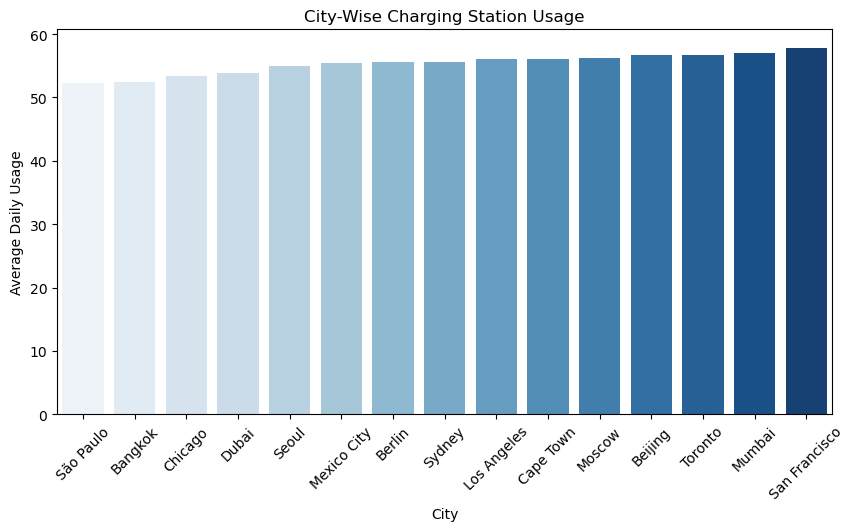

In [ ]:
# This line of code calculates the average daily usage for each city and returns a new DataFrame with columns for "City" and "Usage (avg users/dat)"

city_usage = final_ev_data.groupby("City")["Usage (avg users/day)"].mean().reset_index()
# final_ev_data.groupby("City"): This groups the final_ev_data DataFrame by the "City" column. Each unique city will form it's own group.
# ["Usage (avg users/day)"]: This selects the "Usage (avg users/day)" column grom the grouped data. We're focusing on this specific column within each city group.
# .mean(): This calculates the mean (average) of the "Usage (avg users/day)" column for each city group.
# .reset_index(): This resets the indexof the resulting DataFrame, turning the group labels (city names) back into regular columns instead of being the index.

# This line of code makes the city_usage DataFrame rows reordered so that the cities with the lowest average usage per day appear first, and those with the highest average usage per 
# day appear last.

city_usage = city_usage.sort_values(by='Usage (avg users/day)',ascending=True)
# This function call sorts the rows of the city_usage DataFrame based on the values in the "Usage (avg users/day)" column. The parameter by='Usage (avg users/day)' specifies the column
# to sort by, and ascending=True means the sorting will be ascending order (from the lowest to highest).

# highest_us_city will contain a Series represnting the row with the hightest average usage per day, including the city name and the corresponding usage value.

highest_us_city = city_usage.loc[city_usage["Usage (avg users/day)"].idxmax()]
# city_usage["Usage (avg users/day)"].idxmax(): This part finds the index (row) of the maximum value in the "Usage (avg users/day)" column. It locates the row where the average usage per 
# day is the hightest.
# city_usage.loc[...]: uses the index found in the first step to select the entire row corresponding to the index from the city_usage DataFrame.
# highest_us_city=: Assigns the selected row (the city with the highest average usage per day) to the variable highest_us_city.

# lowest_us_city will contain a Series represnting the row with the lowest average usage per day, including the city name and the corresponding usage value.

lowest_us_city = city_usage.loc[city_usage["Usage (avg users/day)"].idxmin()]
# city_usage["Usage (avg users/day)"].idxmax(): This part finds the index (row) of the minimum value in the "Usage (avg users/day)" column. It locates the row where the average usage per 
# day is the lowest.
# city_usage.loc[...]: uses the index found in the first step to select the entire row corresponding to the index from the city_usage DataFrame.
# lowest_us_city=: Assigns the selected row (the city with the lowest average usage per day) to the variable lowest_us_city.

# This line will output a formatted strin that displays the city with the highest utilization and it's corresponding average usage per day.

print(f"City with Highest Utilization: {highest_us_city['City']} ({highest_us_city['Usage (avg users/day)']:.2f} users/day)")
# f"City with Highest Utilization: {highest_us_city['City']} ({highest_us_city['Usage (avg users/day)']:.2f} users/day)": This is an f-string, which allows embedding expressions inside
# curly braces{}. The values of these expressions are evaluated at runtime and included in the final string.
# {highest_us_city['City']}: inserts the name of the city with the highest usage inside the string.
# {highest_us_city['Usage (avg users/day)']:.2f}: Inserts the average usage per day for the city, formatted to two decimal places.

# This line will output a formatted strin that displays the city with the lowest utilization and it's corresponding average usage per day.

print(f"City with Lowest Utilization: {lowest_us_city['City']} ({lowest_us_city['Usage (avg users/day)']:.2f} users/day)")
# f"City with Lowest Utilization: {lowest_us_city['City']} ({lowest_us_city['Usage (avg users/day)']:.2f} users/day)": This is an f-string, which allows embedding expressions inside
# curly braces{}. The values of these expressions are evaluated at runtime and included in the final string.
# {lowest_us_city['City']}: inserts the name of the city with the lowest usage inside the string.
# {lowest_us_city['Usage (avg users/day)']:.2f}: Inserts the average usage per day for the city, formatted to two decimal places.

# Creates a new figure in Matplotlib

plt.figure(figsize=(10, 5))
# plt.figure(): Creates a new figure. If you don't call the function, Matplotlib will draw on the last figure created.
# figsize=(10, 5)): This parameter specifies the size of the figure in inches. In this case, the figure will be 10 inches wide and 5 inches tall.

# Creates a bar plot using Seaborn.

sns.barplot(x=city_usage["City"], y=city_usage["Usage (avg users/day)"],palette='Blues')
# sns.barplot(...): Creates a bar plot. Seaborn is used here because it provides a high-level interface for drawing attractive and informative statistical graphics.
# x=city_usage["City"]: Specifies the data to be plotted on the x-axis. In this case, it is the "City" column from the city_usage DataFrame.
# y=city_usage["Usage (avg users/day)"]: Specifies the data to be plotted on the y-axis. Here, it is the "Usage (avg users/day)" column from the city_usage DataFrame.
# palette='Blues': Specifies the color palette to be used for the bars. The 'Blues' palette will color the bars in various shades of blue.

# Rotates the labels on the x-axis of your plot by 45 degrees.

plt.xticks(rotation=45)
# plt.xticks(rotation=45): The plt.xticks() function sets the properties of the tick labels on the x-axis. By providing the parameter rotation=45, 
# you specify that the labels should be rotated 45 degrees.

# Sets the label for the x-axis of your plot.

plt.xlabel("City")
# plt.xlabel("City"): This function call sets the label of the x-axis to "City". This is useful for indicating what the values along the x-axis represent, in this case, the cities.

# Sets the label for the y-axis of your plot

plt.ylabel("Average Daily Usage")
# plt.ylabel("Average Daily Usage"): This function call sets the label of the y-axis to "Average Daily Usage". This helps indicate what the values along 
# the y-axis represent—in this case, the average daily usage.

# Sets the title of your plot

plt.title("City-Wise Charging Station Usage")
# plt.title("City-Wise Charging Station Usage"): This function call sets the title of the plot to "City-Wise Charging Station Usage". 
# This helps provide context for the data being visualized.

plt.show()



# City-Wise Charging Station Usage

    ## High Usage: San Francisco,Mumbai, Toronto, Beijing, Moscow, and Cape Town have a lot of peolpe using charging stations every day.

    ## Low Usage: São Paulo has the least number of people using charging stations.

    ## Middle Usage: Cities like Berlin, Mexico City, Dubai, Sydney, and Seoul are the middle in terms of usage.

# Key Takeaways:

    ## Invest More: Add more charging stations in cities like San Francisco and Toronto where a higher number of peolpe use them more.

    ## Understand Demand: Find out why some citeis have high or low habits and needs.

    ## Rasie Awareness: Teach the people in cities with low usage about the benifits of using charging stations.

    ## Plan for Growth: Be ready to expamd in cities with moderate usage as more people start using electric vehicles.

In [ ]:
# Creates a new DataFrame named distance_df that contains a subset of columns from the final_ev_data DataFrame.

distance_df = final_ev_data[['Distance to City (km)','Usage (avg users/day)', 'City']]
# final_ev_data[['Distance to City (km)', 'Usage (avg users/day)', 'City']]: This selects the columns "Distance to City (km)", "Usage (avg users/day)",
# and "City" from the final_ev_data DataFrame.
# distance_df = ...: This assigns the selected subset of columns to the new DataFrame distance_df.
distance_df.head()

,Distance to City (km),Usage (avg users/day),City
1,4.96,83,San Francisco
2,8.54,24,Bangkok
3,13.28,70,Toronto
4,9.76,19,Mumbai
5,2.02,39,São Paulo


In [ ]:
# Create an empty Plotly figure

fig = go.Figure()
# go.Figure(): go refers to the graph objects module in Plotly, and Figure() is a function that creates a new empty figure.
# This figure can later be populated with various types of plots and visual elements.

# Add traces for each city
for city in distance_df['City'].unique():
    # A loop to iterate through each unique city in the distance_df DataFrame.

    city_data = distance_df[distance_df['City'] == city]
    # filters the distance_df DataFrame to include only the rows where the "City" column matches the current city in the loop. 
    # This creates a subset of the data for the specific city being processed in the loop.

    # Adds a scatter plot trace to your figure
    fig.add_trace(go.Scatter(x=city_data['Distance to City (km)'], 
                             y=city_data['Usage (avg users/day)'],
                             mode='markers', name=f'{city} (Data)'))
    
    # Calculate the regression line for the city using linregress
    slope, intercept, _, _, _ = linregress(city_data['Distance to City (km)'], 
                                           city_data['Usage (avg users/day)'])
    
    # Create the regression line
    regression_line_x = np.linspace(city_data['Distance to City (km)'].min(),
                                    city_data['Distance to City (km)'].max(),
                                    100)
    regression_line_y = slope * regression_line_x + intercept
    
    # Plot the regression line
    fig.add_trace(go.Scatter(x=regression_line_x, 
                             y=regression_line_y, 
                             mode='lines', 
                             name=f'{city} (Regression Line)', 
                             line=dict(color='red', dash='dash')))

# Add dropdown menu to filter cities
buttons = []
for city in distance_df['City'].unique():
    visible_list = [trace.name == f'{city} (Data)' or trace.name == f'{city} (Regression Line)' for trace in fig.data]
    buttons.append({'label': city,
                    'method': 'update',
                    'args': [{'visible': visible_list},
                             {'title': f"City-Wise Charging Station Usage: {city}"}]})

fig.update_layout(
    updatemenus=[
        {
            'buttons': buttons,
            'direction': 'down',
            'showactive': True,
        }
    ],
    title="City-Wise Charging Station Usage with Regression Line",
    xaxis_title = 'Distance to City (km)',
    yaxis_title = 'Usage (avg users/day)'
)

# Show the plot
fig.show()

# Charging Station Usage in Cities Based on Distance from City Center.

    ## Data:

    -The scatter plot shows the usage of charging stations based on their distance from the city center.

    - Each blue dot represents a data point, indicating the average number of users per day at different disatance.

    ## Regression Line:

    - The regression line is showing us that overall the distance with in 20km does not have a huge impact on the daily usage in most of the cities showed here.

    ## High Usage Areas:

    - San Francisco:

        - The data points are widely scattered, indicating variability in charging station usage at distance.

        - The regression line has a slight positive slpoe, meaning that, on average, charging station usage slightly increases with distance from the city center.

        - This suggests that fators other than distance, such as location (residential vs. commercial), accessibility, or station capacity, influence usage.

    ## Lower Usage Areas:

    - Chicago:

        -The data appears widely scattered, meaning there is a significant variability in charging station usage.

        - The slope of the regression line is slightly negative, suggesting a week decreasing trend in usage as the distance from the city increases.

        - While there is some decrease in usage with increasing distance, the spread of the points show that charging stations at similar distances can have widely different usage.

    ## In Comparison:

        - San Francisco shows a higher increasing trend in usage as the distance increases, whereas Chicago has a week decreasing trend.

        - Both cities exhibit high variability, meaning distance alone is not a strong predictor of usage.


In [90]:
# 6.  Cost Analysis by City
# Calculate Average Cost per kWh, Visualize with Pie Chart
# ----------------------------------------------------------

#Group Data by City 

# Calculate the average cost and distribution of costs.  

# Geoapify integration for creating mapping usage 

# Pie Chart for cost distribution 

# Build 1-2 Data Visualizations for cost differences across regions 